In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import skimage
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float64') / 255.
X_test = X_test.astype('float64') / 255.
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))


(60000, 28, 28, 1)

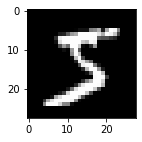

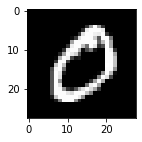

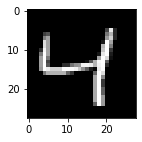

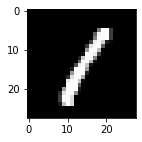

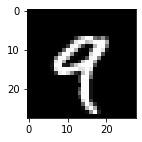

In [ ]:
#have a look on images:

for i in range(5):
  plt.figure(figsize = (2,2))
  plt.imshow(X_train[i].reshape(28, 28), cmap = 'gray')
  plt.show()

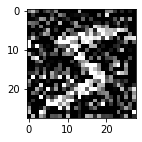

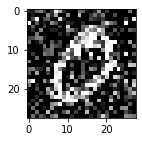

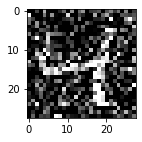

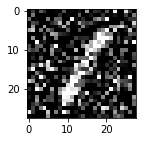

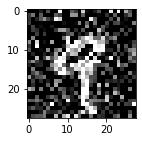

In [ ]:
#add noise:

X_train_noisy = skimage.util.random_noise(X_train, mode='gaussian', var=0.2)
X_test_noisy = skimage.util.random_noise(X_test, mode='gaussian', var=0.2)

#and have a look on noisy images:

for i in range(5):
  plt.figure(figsize = (2,2))
  plt.imshow(X_train_noisy[i].reshape(28, 28), cmap = 'gray')
  plt.show()

In [ ]:
#autoencoder:

input = keras.Input(shape=(28, 28, 1))

x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 14, 14, 32)        0   

In [ ]:
autoencoder.fit(X_train_noisy, X_train,
                epochs=10,
                batch_size=128,
                shuffle=True)

Epoch 1/10
469/469 [==============================] - 137s 291ms/step - loss: 0.2583
Epoch 2/10
469/469 [==============================] - 136s 290ms/step - loss: 0.1074
Epoch 3/10
469/469 [==============================] - 135s 288ms/step - loss: 0.1014
Epoch 4/10
469/469 [==============================] - 136s 289ms/step - loss: 0.0986
Epoch 5/10
469/469 [==============================] - 135s 288ms/step - loss: 0.0966
Epoch 6/10
469/469 [==============================] - 135s 287ms/step - loss: 0.0951
Epoch 7/10
469/469 [==============================] - 135s 287ms/step - loss: 0.0940
Epoch 8/10
469/469 [==============================] - 135s 287ms/step - loss: 0.0931
Epoch 9/10
469/469 [==============================] - 135s 288ms/step - loss: 0.0925
Epoch 10/10
469/469 [==============================] - 135s 288ms/step - loss: 0.0918


In [ ]:
X_test_denoised = autoencoder.predict(X_test_noisy)
X_train_denoised = autoencoder.predict(X_train_noisy)

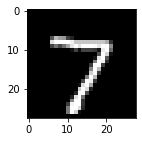

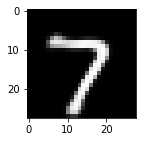

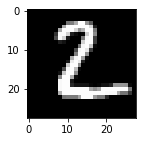

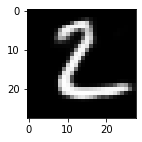

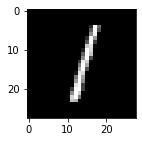

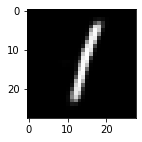

In [ ]:
for i in range(3):
  plt.figure(figsize = (2,2))
  plt.imshow(X_test[i].reshape(28, 28), cmap = 'gray')
  plt.show()
  plt.figure(figsize = (2,2))
  plt.imshow(X_test_denoised[i].reshape(28, 28), cmap = 'gray')
  plt.show()

In [ ]:
#classification network:

c_model = Sequential()

c_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
c_model.add(LeakyReLU(0.1))
c_model.add(MaxPooling2D((2, 2)))
c_model.add(Dropout(0.25))

c_model.add(Flatten())

c_model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
c_model.add(LeakyReLU(0.1))
c_model.add(Dropout(0.5))
c_model.add(Dense(10))
c_model.add(Activation("softmax"))

c_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               627300    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100)              

In [ ]:
c_model.compile(
    loss='categorical_crossentropy',  
    optimizer=keras.optimizers.Adamax(), 
    metrics=['accuracy']
)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
c_model.fit(X_train, y_train, 
    batch_size=32,
    epochs=5,
    verbose=0
)

In [ ]:
eval_test = c_model.evaluate(X_test, y_test)
print('test loss, test accuracy:', eval_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0428 - accuracy: 0.9861
test loss, test accuracy: [0.042775318026542664, 0.9861000180244446]


In [ ]:
eval_noisy = c_model.evaluate(X_test_noisy, y_test)
print('noisy loss, noisy accuracy:', eval_noisy)

313/313 [==============================] - 3s 8ms/step - loss: 2.3869 - accuracy: 0.5743
noisy loss, noisy accuracy: [2.3869168758392334, 0.5742999911308289]


In [ ]:
eval_denoised = c_model.evaluate(X_test_denoised, y_test)
print('denoised loss, denoised accuracy:', eval_denoised)

313/313 [==============================] - 2s 8ms/step - loss: 0.1068 - accuracy: 0.9656
denoised loss, denoised accuracy: [0.1068260595202446, 0.9656000137329102]
